# Employee Group Project 23

##### By Tracy Gan, Aronn Laurel, Nikita Prabhu, Nolan Vu


### Data Description

We will work on the [Employee Dataset on Kaggle](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset) which contains information about the employees in the company, including their personal information such as age, gender, educational background, years of experience, salary tier, and the city where they work. The dataset also contains their information in regards to the company, such as the year they joined, and if they were ever benched. Specifically, each variable is broken down into

| Variable Name     | Type of Variable | Description |
|-------------------|------------------|-------------|
| Education         | Categorical  | It represents the educational qualities of employees. There are three unique levels for this categorical variable, which are Bachelors, Masters, and PHD.   |
| JoiningYear       | Categorical  | It represents the year each employee joined the company, which also indicates the length of their service to the company.  |
| City              | Categorical  | It represents the city where the employee works at. There are three unique values for this categorical variable, which are Bangalore, Pune, New Delhi.      |
| PaymentTier         | Categorical  | Categorization of employees into various salary levels (1-3)   |
| Age       | Continuous  | Employee Age  |
| Gender              | Categorical  | Employee Gender (Male/Female)  |
| EverBenched         | Categorical  | Whether an employee has ever been temporarily unassigned to work (Yes/No) |
| ExperienceInCurrentDomain       |  Continuous | Number of years of experience employees have in their current field |
| LeaveOrNot              | Categorical  | Our project's Target column, whether an employee will leave the company or not (0:Leave 1:Stay)     |

In total, there are 9 variables and 4653 rows of observation for each column with no missing values for any of the variables. This Employee dataset, found on Kaggle, came from the contributions of a HR department of a company, of which is anonymized as well as the people who contribute to this dataset. 

### Question

With this dataset, we are interested in mainly two questions. 
1. Can age, the year they joined and their payment tier be used to predict whether an employee would leave the company?
2. Does education, gender and experience in the current domain affect the payment tier?

### Aronn's Question (Planning Stage)
> Can educational qualifications, payment tier, age, and work experience reliably predict whether an employee will take leave?
> 
My question covers a prediction question about the dataset which I will conduct some exploratory data analysis and visualisation to answer the question.

In [63]:
# Firstly, we will load some libraries so that we can perform data analysis and visualisation to answer our question.

# Loading Libraries
#library(tidymodels)
library(tidyverse)
library(dplyr)
library(forcats)
library(ggplot2)
library(corrplot)
library(cowplot)
library(GGally)
library(glmnet)
library(leaps)
library(Metrics)
library(pROC)
library(caret)
library(broom)

In [64]:
employee_data <- read_csv('data/Employee.csv')
head(employee_data)

Rows: 4653 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


#### Since the Kaggle data does not include information on the Payment Tier categorization, we will try interpret the 3 payment tiers with a bar plot.

In [65]:
count_data <- employee_data %>%
    group_by(PaymentTier, Education) %>%
    summarise(count = n(), .groups = 'drop')

plot1 <- ggplot(count_data, aes(x = Education, y = count, fill = PaymentTier)) +
    geom_bar(stat = "identity", position = "fill") + 
    labs(title = "Proportional Bar Plot of Payment Tier and Education",
         x = "Education",
         y = "Proportion") +
    theme_minimal()

pt_count <- employee_data %>%
    group_by(PaymentTier) %>%
    summarise(count = n(), .groups = 'drop')

plot2 <- ggplot(pt_count, aes(x = PaymentTier, y = count)) +
    geom_bar(stat = "identity") +
    labs(title = "Payment Tier Count",
         x = "Payment Tier",
         y = "Count") +
    theme_minimal()


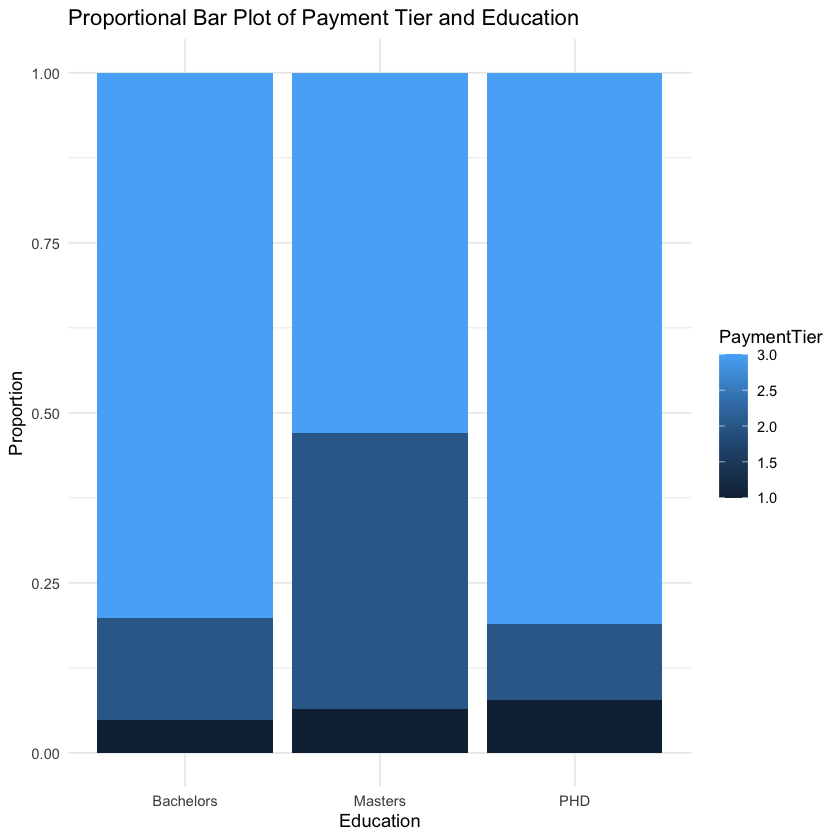

In [66]:
plot1

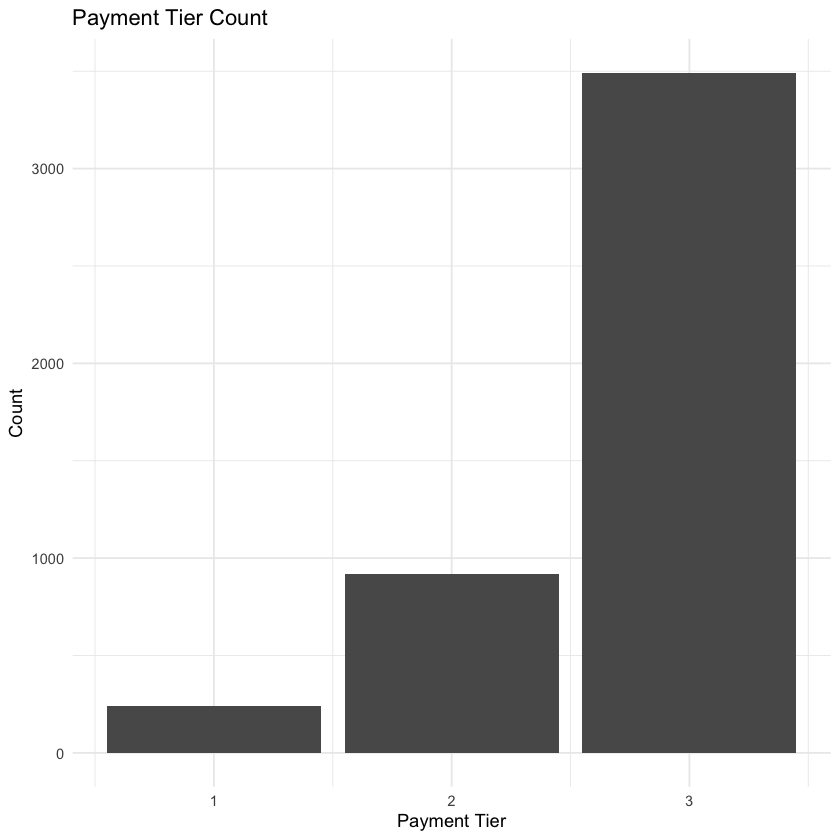

In [6]:
plot2

Looking at both barplots, it suggests that Payment Tier is in a decreasing order, with 3 being the common payment tier among all to 1 being the highest payment tier. We will use ordinal encoding for Payment Tier because it represent a ranked order, where each tier indicates a specific level of payment with 1 being the highest paid and 3 being the lowest. 


Overall our data does not have any missing values, nor is there inconsistency within our dataset. Hence, the cleaning and wrangling of the dataset will focus on removing variables that we are not interested in as well as conducting appropriate encoding techniques for our categorical variables.

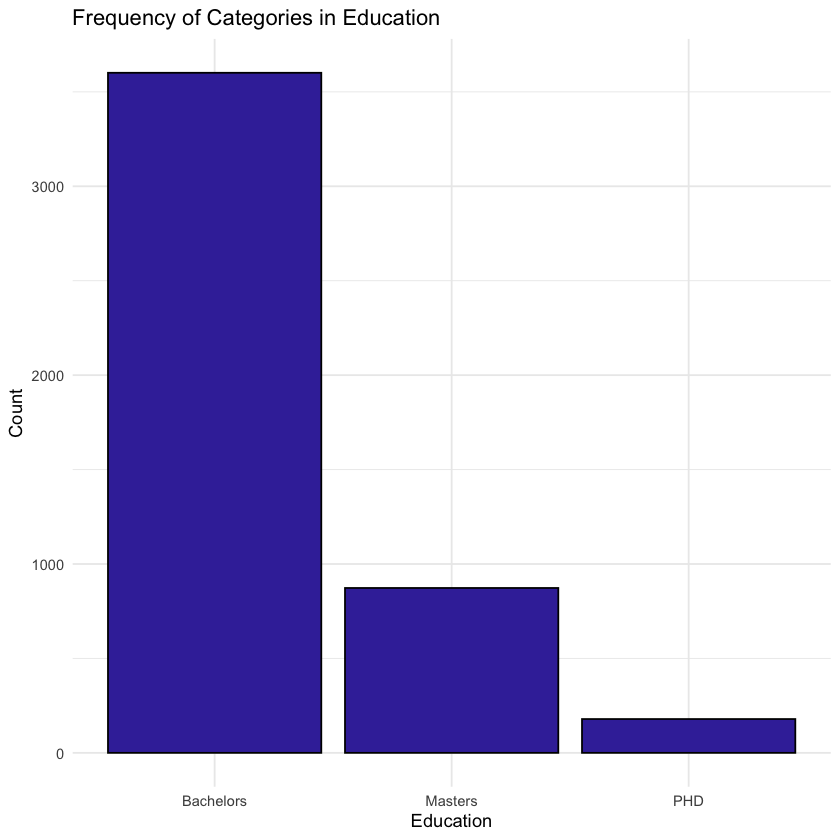

In [7]:
ggplot(employee_data, aes(x = Education)) +
  geom_bar(fill = "#3e32a8", color = "black") +
  labs(title = "Frequency of Categories in Education",
       x = "Education",
       y = "Count") +
  theme_minimal()

For Education, we will create a new column "Edu_level" that uses Ordinal Encoding on Education as it does represent an increasing order as we go from Bachelors, Masters to PHD.

In [62]:
employee_data <- employee_data %>%
    mutate(
        Education = as.numeric(factor(Education)),
        City = as.numeric(factor(City)),
        Gender = as.numeric(factor(Gender)),
        EverBenched = as.numeric(factor(EverBenched)),
        LeaveOrNot = as.numeric(LeaveOrNot)
    )

head(employee_data)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017,1,3,34,2,1,0,0
1,2013,3,1,28,1,1,3,1
1,2014,2,3,38,1,1,2,0
2,2016,1,3,27,2,1,5,1
2,2017,3,3,24,2,2,2,1
1,2016,1,3,22,2,1,0,0


## Data Visualisation & Analysis

Checking for distribution of variables

In [9]:
names(employee_data)

[1] "Education"                 "JoiningYear"              
[3] "City"                      "PaymentTier"              
[5] "Age"                       "Gender"                   
[7] "EverBenched"               "ExperienceInCurrentDomain"
[9] "LeaveOrNot"

In [10]:
education_plot <- employee_data |>
                    ggplot(aes(x = Education)) +
                    geom_bar(fill = "lightblue") +
                    labs(title = "Distribution of Employee Education level",
                         x = "Highest Education level attained",
                         y = "Count") +
                    theme_minimal()

joiningYear_plot <- employee_data |>
                    ggplot(aes(x = JoiningYear)) +
                    geom_histogram(fill = "lightblue") +
                    labs(title = "Distribution of Employee Joining year",
                         x = "Joining Year",
                         y = "Count") +
                    theme_minimal()

city_plot <- employee_data |>
                    ggplot(aes(x = City)) +
                    geom_bar(fill = "lightblue") +
                    labs(title = "Distribution of Employee City Origin",
                         x = "City",
                         y = "Count") +
                    theme_minimal()

paymentTier_plot <- employee_data |>
                    ggplot(aes(x = PaymentTier)) +
                    geom_bar(fill = "lightblue") +
                    labs(title = "Distribution of Employee Payment Tier",
                         x = "Payment Tier",
                         y = "Count") +
                    theme_minimal()

age_plot <- employee_data |>
                    ggplot(aes(x = Age)) +
                    geom_histogram(fill = "lightblue", binwidth = 5) +
                    labs(title = "Distribution of Employee Age",
                         x = "Age",
                         y = "Count") +
                    theme_minimal()

gender_plot <- employee_data |>
                    ggplot(aes(x = Gender)) +
                    geom_bar(fill = "lightblue") +
                    labs(title = "Distribution of Employee Gender",
                         x = "Gender",
                         y = "Count") +
                    theme_minimal()

everBenched_plot <- employee_data |>
                    ggplot(aes(x = EverBenched)) +
                    geom_bar(fill = "lightblue") +
                    labs(title = "Distribution of Employee ever Benches",
                         x = "Ever Benched",
                         y = "Count") +
                    theme_minimal()

experienceInCurrentDomain_plot <- employee_data |>
                    ggplot(aes(x = ExperienceInCurrentDomain)) +
                    geom_histogram(fill = "lightblue") +
                    labs(title = "Distribution of Employee years of experience in Domain",
                         x = "Years of experience in Domain",
                         y = "Count") +
                    theme_minimal()

LeaveOrNot_plot <- employee_data |>
                    ggplot(aes(x = LeaveOrNot)) +
                    geom_histogram(fill = "lightblue") +
                    labs(title = "Distribution of Employee Leaving Or Not",
                         x = "Leave Or Not",
                         y = "Count") +
                    theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


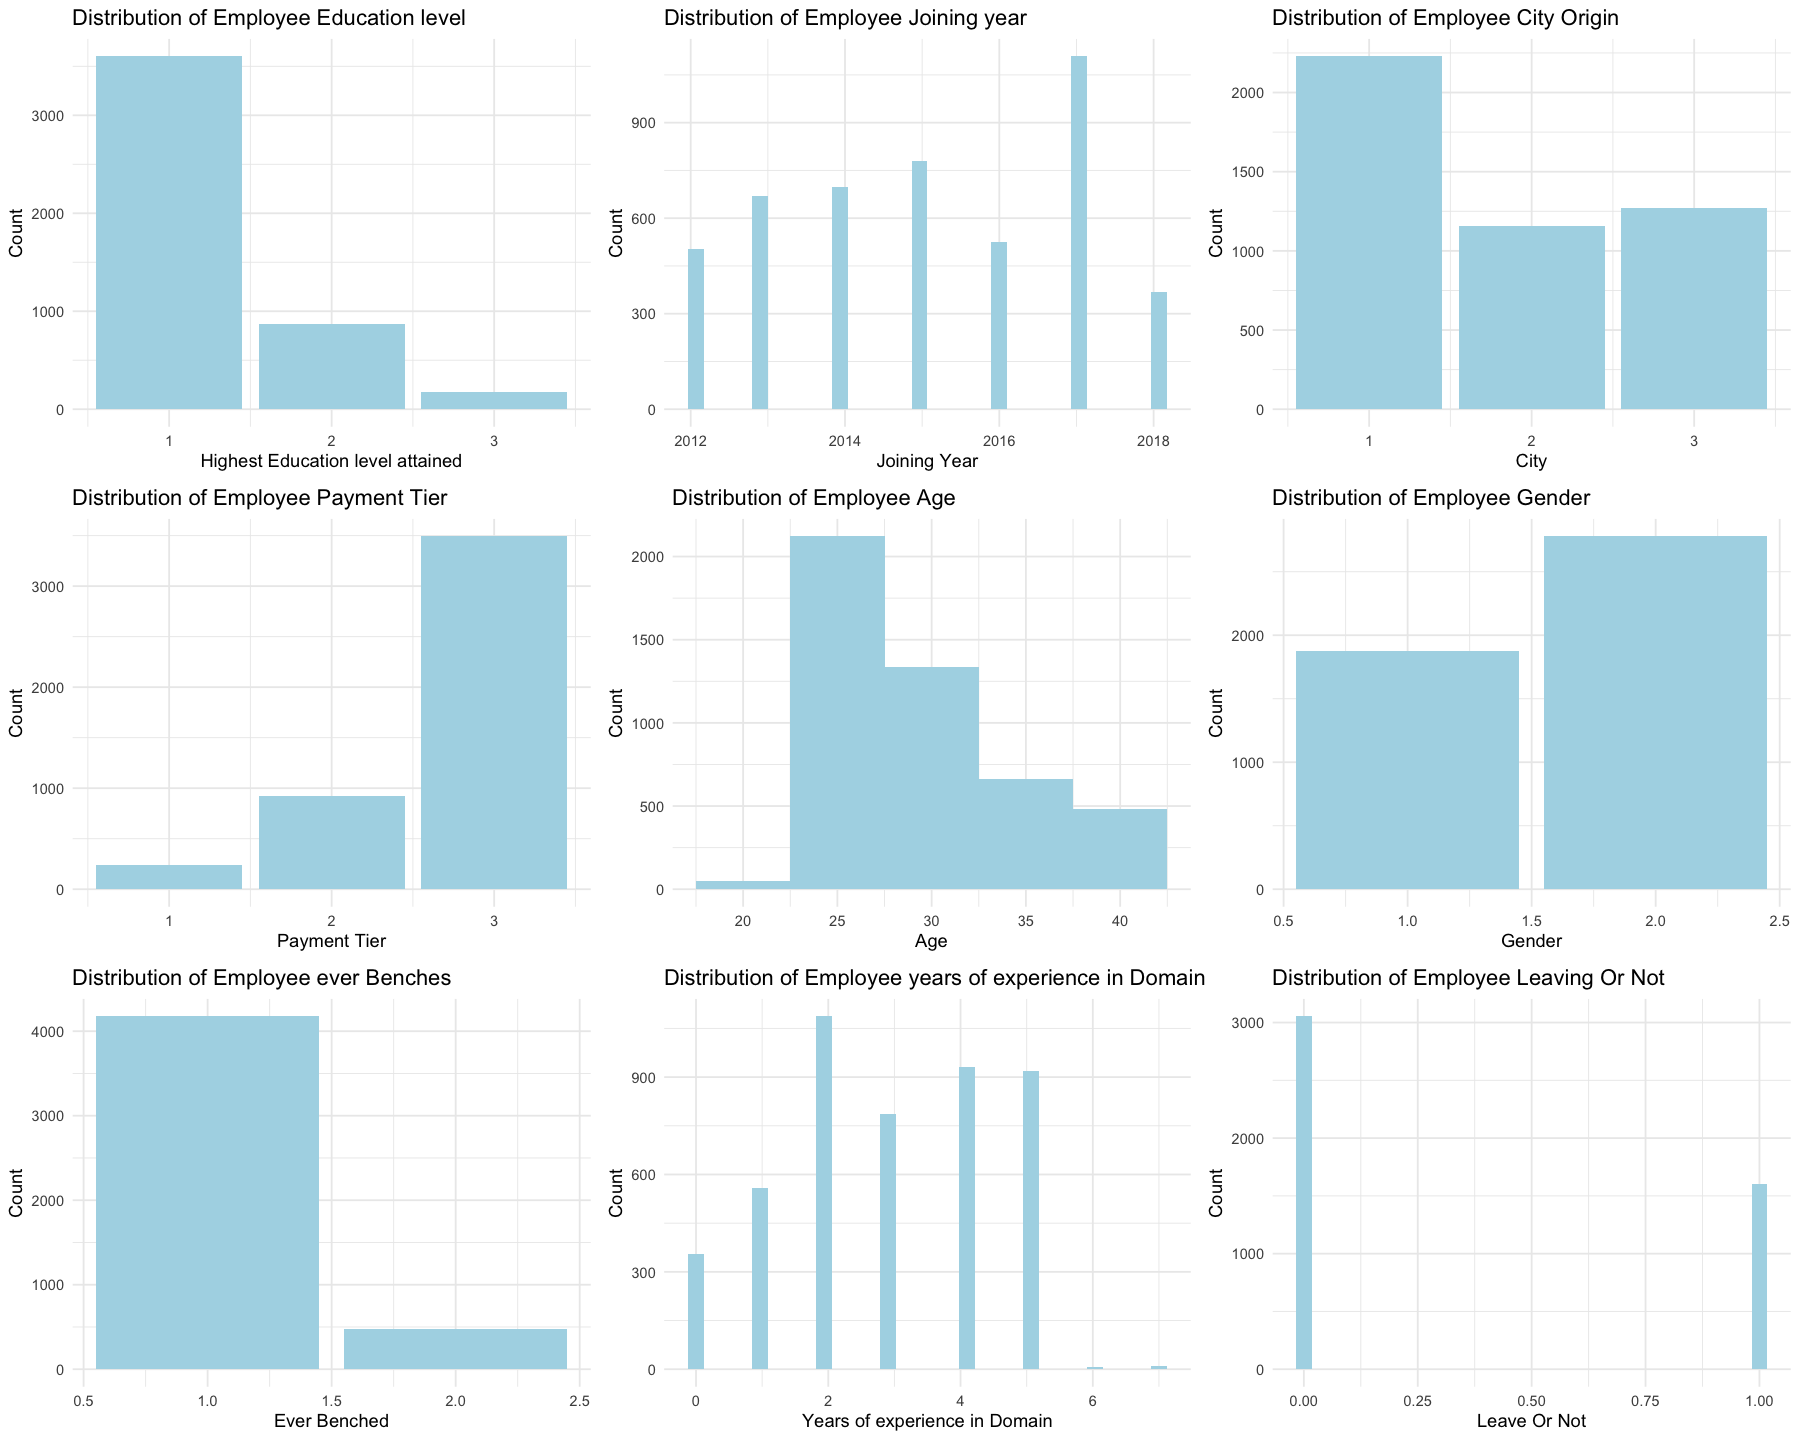

In [11]:
options(repr.plot.width = 15, repr.plot.height = 12) 
plot_grid(education_plot, joiningYear_plot, city_plot, paymentTier_plot, age_plot, gender_plot, everBenched_plot, experienceInCurrentDomain_plot, LeaveOrNot_plot, ncol = 3, nrow=3)

Overall, the predictor plots above provide insight into the distribution of each predictor variable, allowing us to hypothesize which factors might be associated with LeaveOrNot. Furthermore, we see that education levels (Masters, Phd), Employee city (New Delhi, Pune), Employees ever benched, and Age at 20 may be under-represented in this dataset. Below, we will further look into the proportion of employees leaving or not based off the other factors.

In [12]:
edu_leave_plot <- ggplot(employee_data, aes(x = Education, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") +  
    labs(title = "Proportion of Employees Leaving by Education",
         x = "Education",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

join_leave_plot <- ggplot(employee_data, aes(x = JoiningYear, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") +  
    labs(title = "Proportion of Employees Leaving by Payment Tier",
         x = "Joining year",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

city_leave_plot <- ggplot(employee_data, aes(x = City, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") + 
    labs(title = "Proportion of Employees Leaving by City",
         x = "City",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

pay_leave_plot <- ggplot(employee_data, aes(x = PaymentTier, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") + 
    labs(title = "Proportion of Employees Leaving by Payment Tier",
         x = "Payment Tier",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

age_leave_plot <- ggplot(employee_data, aes(x = Age, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") +  
    labs(title = "Proportion of Employees Leaving by Age",
         x = "Age",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

gender_leave_plot <- ggplot(employee_data, aes(x = Gender, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") + 
    labs(title = "Proportion of Employees Leaving by Gender",
         x = "Gender",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

EverBenched_leave_plot <- ggplot(employee_data, aes(x = EverBenched, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") +
    labs(title = "Proportion of Employees Leaving by EverBenched",
         x = "Employee ever been benched",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

ExperienceInCurrentDomain_leave_plot <- ggplot(employee_data, aes(x = ExperienceInCurrentDomain, fill = factor(LeaveOrNot))) +
    geom_bar(position = "fill") + 
    labs(title = "Proportion of Employees Leaving by Experience in domain",
         x = "Experience in domain",
         y = "Proportion",
         fill = "Left the Company") +
    theme_minimal()

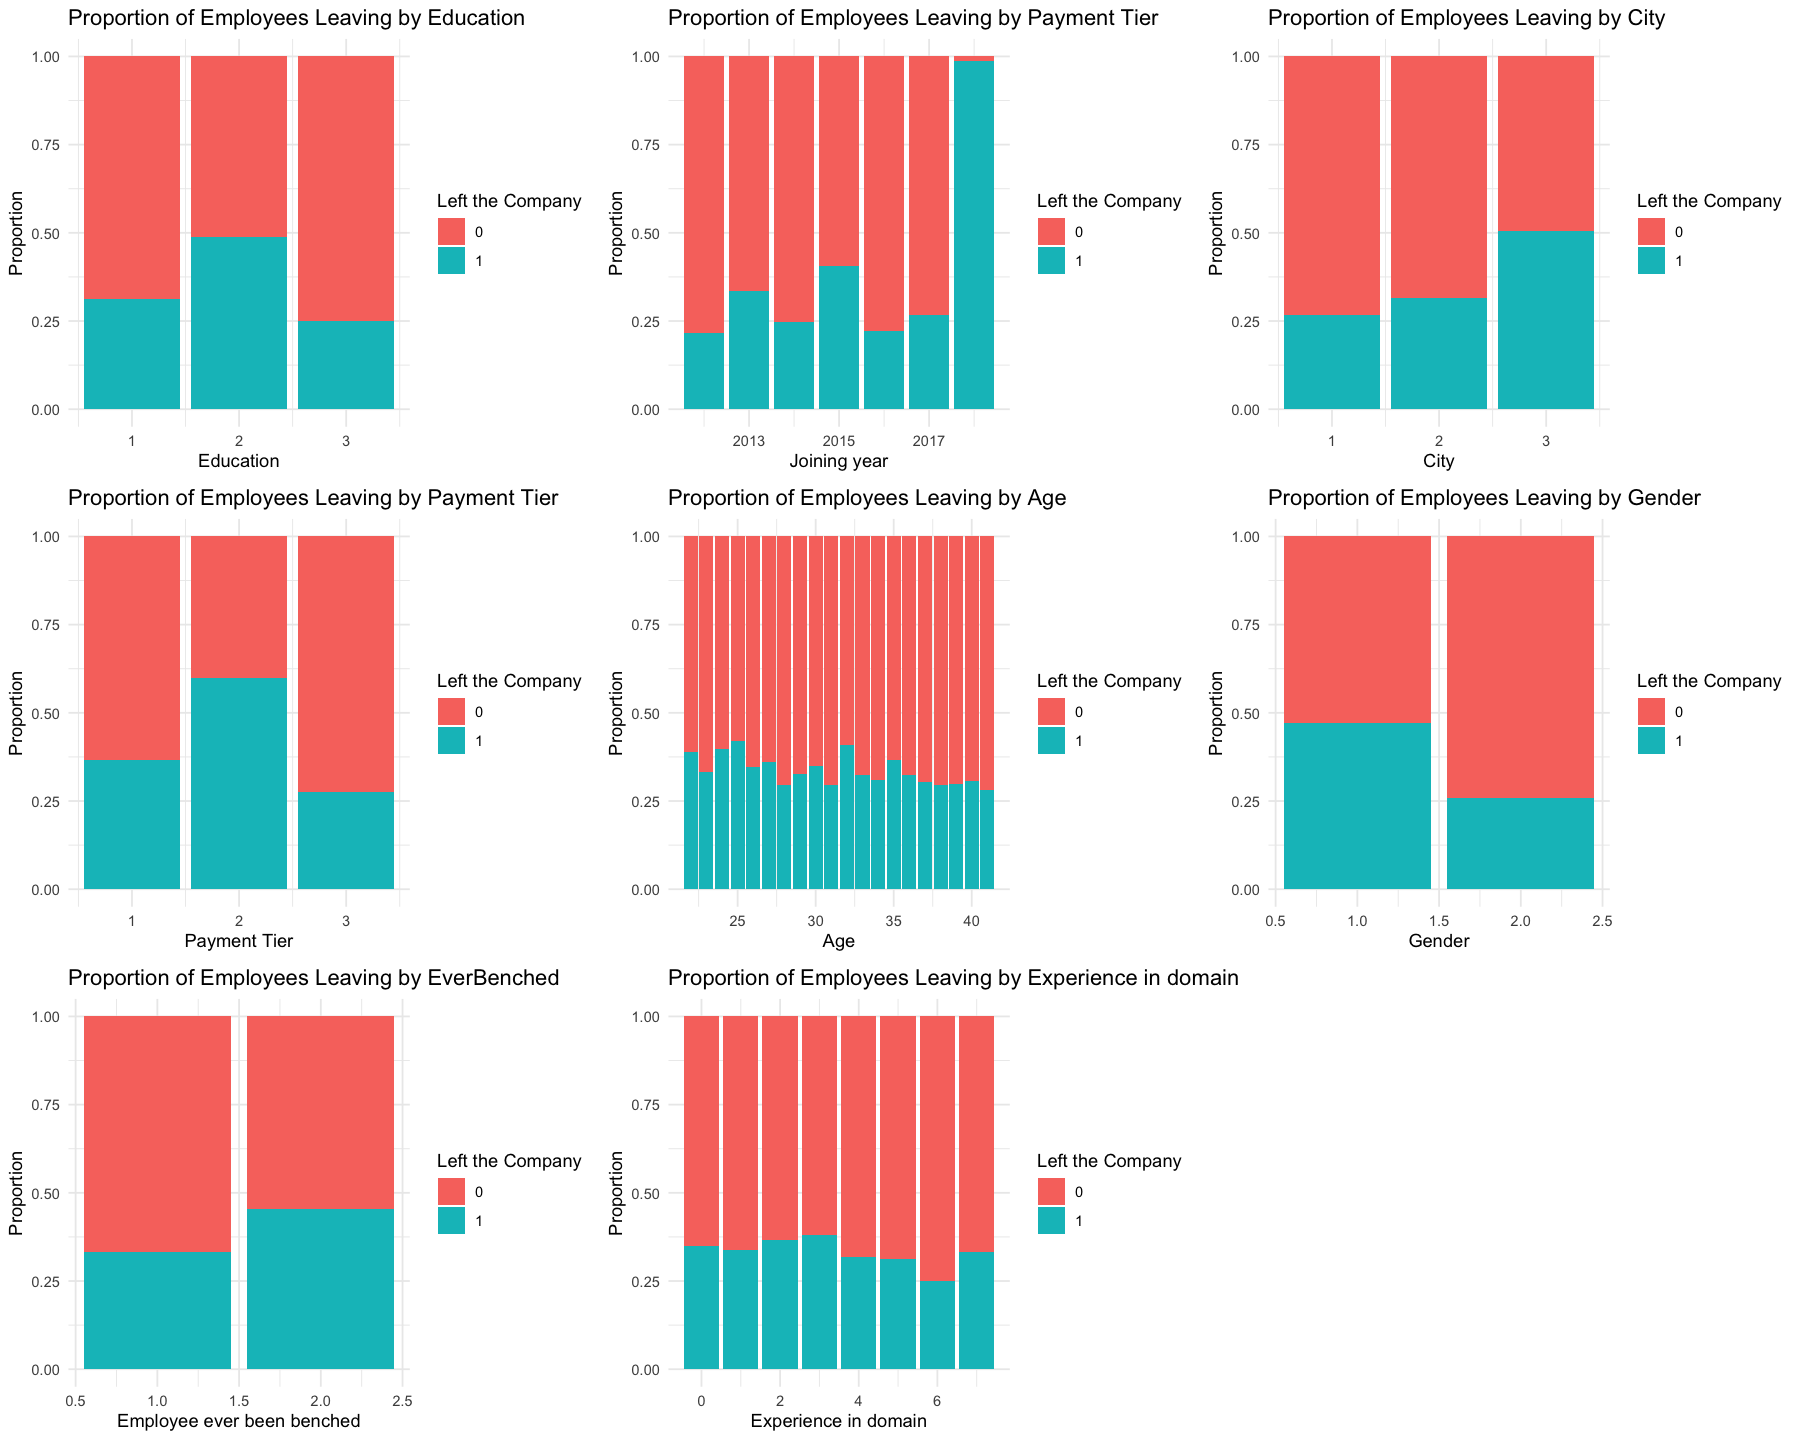

In [13]:
options(repr.plot.width = 15, repr.plot.height = 12) 
plot_grid(edu_leave_plot, join_leave_plot, city_leave_plot, pay_leave_plot, age_leave_plot, gender_leave_plot, EverBenched_leave_plot,ExperienceInCurrentDomain_leave_plot, ncol = 3, nrow=3)

Based on the plots above, we observed that Employees who join after 2017 are most likely to stay than leave while there is a major turnover rate of Employees from 2012 to 2017. Furthermore, we see that factors such as Age, Education, EverBenched, Experience in Domain, and City are all relatively similar within each category with a higher leaving rate than staying. Overall, we see that all factors involve a higher leaving rate for all factors except for Employees who joined after 2017. 

To check for collinearity between variables, we will be using a **Correlation Matrix** plot to check if there are any highly correlated variables

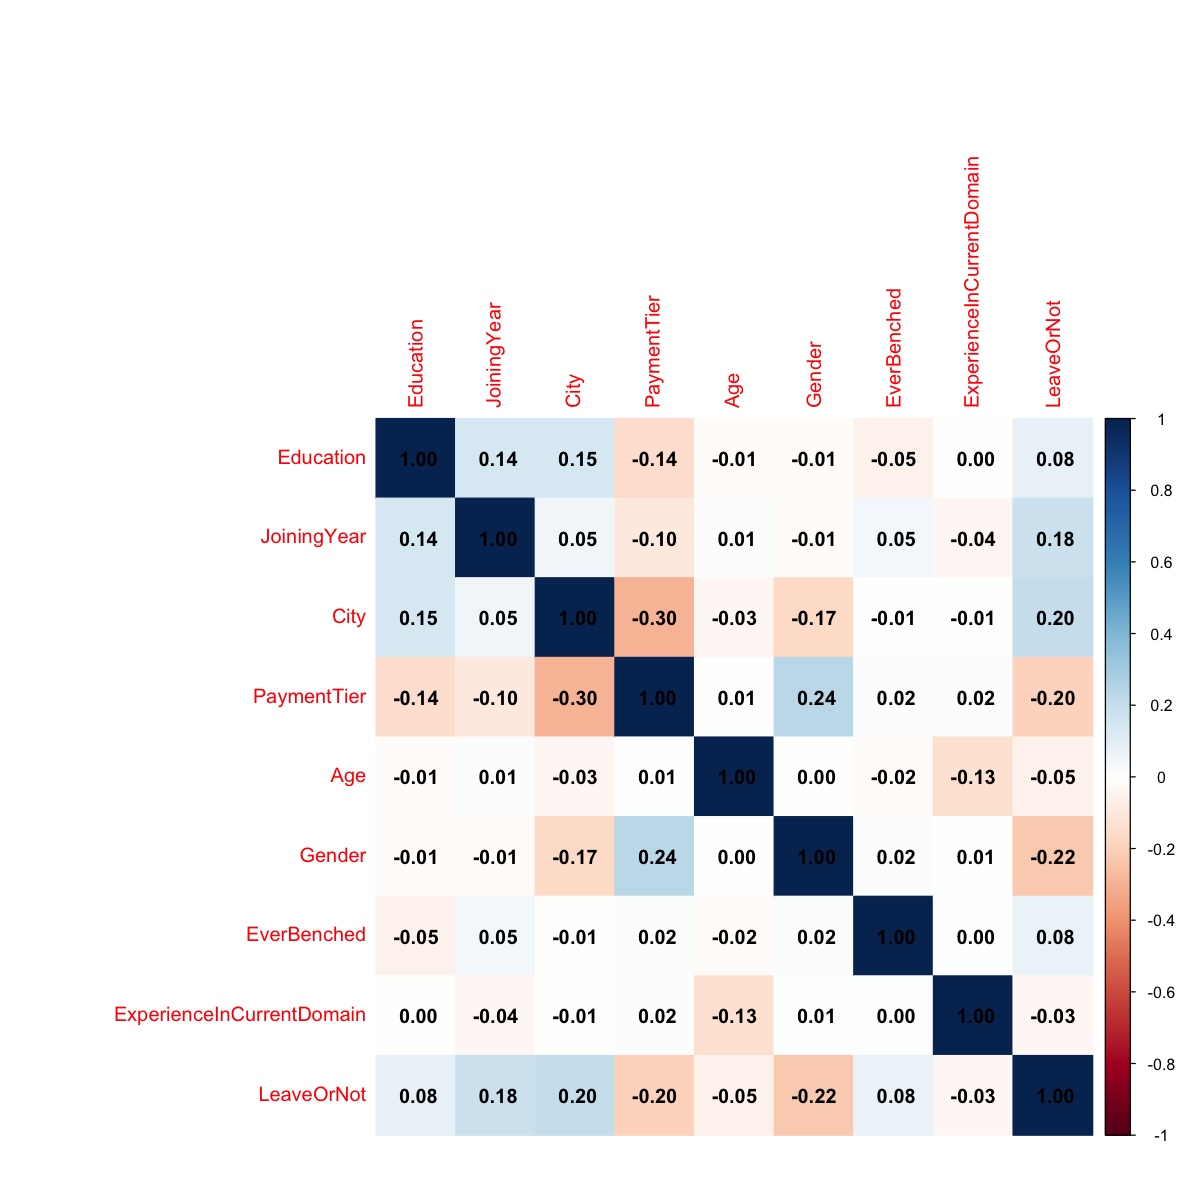

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10) 
cor_matrix <- cor(employee_data, use = "complete.obs")

# Correlation matrix
corrplot(cor_matrix, method = "color", addCoef.col = "black")

Above is the correlation coefficient heat map between LeaveOrNot and other predictor variables, the correlation matrix reveals an overall weak correlation betweem all variables with nothing over 0.5/-0.5. Additionally, there are weak negative correlations for variables Age, Gender, PaymentTier, and ExperienceInCurrentDomain while the other variables shows weak positive correlations. These results indicate that the individual predictors are not strongly related to the likelihood of leaving, however, we still need to be concerned for multi-collinearity when integrating different variables into our model.

In conclusion, we only see minimal correlation between employee factors and their likelihood of leaving the company. Given the lack of strong visual patterns, we will proceed with **forward** or **backward elimination** to identify the best predictors for the model, and allowing us to select the best covariates.

## Methods and Plan

### Why is this method appropriate?
Since we have a binary classification problem with the target column `LeaveOrNot` (1 = Leave, 0 = Stay), a logistic regression model is more suitable because we found that mostly non-linear relationship between our input variables and target. Additionally, the logistic function produces an S-shaped curve that transforms any real number to a value ranging from 0 and 1. For our project, I have picked Ridge over Lasso Regression because my project question is aiming for a better overall prediction.
I will also be implementing Ridge Regularization (L2 Penalty) to address any multi-collinearity among predictors to prevent our logistic regression model from over-fitting. Additionally, it also helps us penalize any large coefficients that can improve generalisation for new unforeseen data. 


### Which assumptions are required, if any, to apply the method selected?
1) Based on the heat map above, we can see that there could be minimal multi-collinearity issues as we do not see any predictors with correlation above 0.3 or below -0.3, however, we will be applying L2 regularization in our Ridge Regression model to handle any multi-collinearity problems.
3) Using Ridge Regression means we will need to assume a linear relationship between predictors and the log-odds 

### What are the potential limitations or weaknesses of the method selected?
1) If non-linear relationships exist between predictors and the target, Logistic Regression might not capture these effectively and model performance may be poorer unless we apply transformations.
2) There could exist perfect multi-collinearity such as duplicated predictors which can still cause issues after Ridge Regularization.
3) Using Logistic Regression, we won't be able to capture full complex interaction terms between predictors.

## Implementation of a proposed model (Ridge Logistic Regression)

#### 1) Obtaining Samples
To build our predictive model, we will split our dataset into a training set and a testing set, where 70% of the data is dedicated for the training set and 30% for the testing set.

In [38]:
# From Worksheet 6 and Tutorial 7
set.seed(123)

# Sample 
emp_sample <- employee_data

# 70% Randomly Selected Rows as Training data
training_emp = emp_sample %>%
  sample_frac(0.7)

# The rest of the sample data as Testing data that is not in the 30%
testing_emp = emp_sample %>%
  setdiff(training_emp)

In [39]:
head(training_emp)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015,3,3,28,2,1,1,0
1,2014,1,3,29,2,1,1,0
2,2017,2,3,26,2,1,4,1
1,2015,1,3,25,2,1,3,0
2,2017,2,2,31,2,1,4,0
1,2013,1,3,26,2,1,4,0


#### 2) Using Forward Selection for Feature Selection

In [18]:
# identifies various subsets of input variables selected for models of different sizes
emp_forward_sel <- regsubsets(x = LeaveOrNot ~ .,
                              nvmax = 8, # Max 8 Features can be considered for Selection 
                              data = training_emp,
                              method = "forward")
emp_forward_sel

Subset selection object
Call: regsubsets.formula(x = LeaveOrNot ~ ., nvmax = 8, data = training_emp, 
    method = "forward")
10 Variables  (and intercept)
                          Forced in Forced out
EducationMasters              FALSE      FALSE
EducationPHD                  FALSE      FALSE
JoiningYear                   FALSE      FALSE
CityNew Delhi                 FALSE      FALSE
CityPune                      FALSE      FALSE
PaymentTier                   FALSE      FALSE
Age                           FALSE      FALSE
GenderMale                    FALSE      FALSE
EverBenchedYes                FALSE      FALSE
ExperienceInCurrentDomain     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: forward

In [19]:
emp_fwd_summary <- summary(emp_forward_sel)
emp_fwd_summary

Subset selection object
Call: regsubsets.formula(x = LeaveOrNot ~ ., nvmax = 8, data = training_emp, 
    method = "forward")
10 Variables  (and intercept)
                          Forced in Forced out
EducationMasters              FALSE      FALSE
EducationPHD                  FALSE      FALSE
JoiningYear                   FALSE      FALSE
CityNew Delhi                 FALSE      FALSE
CityPune                      FALSE      FALSE
PaymentTier                   FALSE      FALSE
Age                           FALSE      FALSE
GenderMale                    FALSE      FALSE
EverBenchedYes                FALSE      FALSE
ExperienceInCurrentDomain     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: forward
         EducationMasters EducationPHD JoiningYear CityNew Delhi CityPune
1  ( 1 ) " "              " "          " "         " "           " "     
2  ( 1 ) " "              " "          "*"         " "           " "     
3  ( 1 ) " "              " "          "*"   

In [20]:
emp_summary <- tibble(
   n_input_variables = 1:8,
   RSS = emp_fwd_summary$rss,
   BIC = emp_fwd_summary$bic,
   Cp = emp_fwd_summary$cp
)
emp_summary

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,699.5713,-131.5187,359.10708
2,675.9049,-235.5206,238.91027
3,652.7543,-340.9439,121.37616
4,644.8011,-372.7827,82.31124
5,640.3400,-387.3061,61.27728
6,636.3025,-399.8186,42.43050
7,632.9184,-409.0984,26.95720
8,629.9238,-416.4567,13.49502


After applying **Forward Selection** to get the best model for each size of input variables, we will select the best one in terms of the out-of-sample prediction accuracy, as measured by Cp and BIC. I chose BIC as the selection criterion because it penalizes the number of parameters similar to ridge regression models, where we can get a goodness of fit with the model complexity. On the otherhand, I also consider Mallow's Cp because it can provide my model the best trade-off between prediction accuracy and model complexity, minimizing the bias and variance. <br>

Based on the table above, I will be picking **8** input variables (All Features) as it produces the smallest Cp Value (9.00) and a fairly small BIC value. Although 2 or 3 input variables have relatively smaller BIC values, I did not choose them as they have significantly larger Cp values.

#### 3) Using Cross Validation to find $\lambda$ with the Highest AUC 
Now that we have eliminated any irrelevant predictors, our next goal is **maximizing** the Area Under the Curve (AUC). The best lambda for the Ridge Regression would be represented with the highest AUC which would be `lambda.min` in the following code:

In [21]:
set.seed(123)

# Preparing model matrix for `glmnet` (using all predictors)
emp_X_train <- model.matrix(object = LeaveOrNot ~ .,
                            data = training_emp)[, -1]

emp_Y_train <- training_emp[["LeaveOrNot"]]

emp_X_test <- model.matrix(object = LeaveOrNot ~ .,
  data = testing_emp)[, -1]

emp_Y_test <- testing_emp[["LeaveOrNot"]]

# Ridge Regression
emp_cv_lambda_ridge <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 0,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_cv_lambda_ridge


# Lasso Regression
emp_cv_lambda_lasso <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 1,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_cv_lambda_lasso


Call:  cv.glmnet(x = emp_X_train, y = emp_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min   0.01    97  0.7248 0.01153      10
1se  90.95     2  0.7203 0.01231      10


Call:  cv.glmnet(x = emp_X_train, y = emp_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

      Lambda Index Measure      SE Nonzero
min 0.000953    51  0.7257 0.01271      10
1se 0.020528    18  0.7135 0.01192       7

#### 4) Analyzing and Visualizing Estimated Test AUC

In [22]:
emp_lambda_max_AUC_ridge <- emp_cv_lambda_ridge$lambda.min
emp_lambda_max_AUC_ridge

emp_lambda_max_AUC_lasso <- emp_cv_lambda_lasso$lambda.min
emp_lambda_max_AUC_lasso

[1] 0.01319583

[1] 0.0009528454

In [23]:
set.seed(123)
emp_ridge_max_AUC <- glmnet(
        x = emp_X_train,
        y = emp_Y_train,
        alpha = 0,
        family = "binomial",
        lambda = emp_lambda_max_AUC_ridge)

emp_ridge_max_AUC
coef(emp_ridge_max_AUC)

# LASSO
emp_lasso_max_AUC <- glmnet(
        x = emp_X_train,
        y = emp_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = emp_lambda_max_AUC_lasso)

emp_ridge_max_AUC
coef(emp_lasso_max_AUC)


Call:  glmnet(x = emp_X_train, y = emp_Y_train, family = "binomial",      alpha = 0, lambda = emp_lambda_max_AUC_ridge) 

  Df  %Dev Lambda
1 10 11.34 0.0132

11 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -389.52636560
EducationMasters             0.64090611
EducationPHD                 0.04454686
JoiningYear                  0.19404684
CityNew Delhi               -0.38313504
CityPune                     0.61695961
PaymentTier                 -0.32011304
Age                         -0.03240573
GenderMale                  -0.83702517
EverBenchedYes               0.54399618
ExperienceInCurrentDomain   -0.05895372


Call:  glmnet(x = emp_X_train, y = emp_Y_train, family = "binomial",      alpha = 0, lambda = emp_lambda_max_AUC_ridge) 

  Df  %Dev Lambda
1 10 11.34 0.0132

11 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -414.58859571
EducationMasters             0.68020842
EducationPHD                 0.04357098
JoiningYear                  0.20651866
CityNew Delhi               -0.42308601
CityPune                     0.63657874
PaymentTier                 -0.31658400
Age                         -0.03423578
GenderMale                  -0.89397028
EverBenchedYes               0.56620641
ExperienceInCurrentDomain   -0.06035132

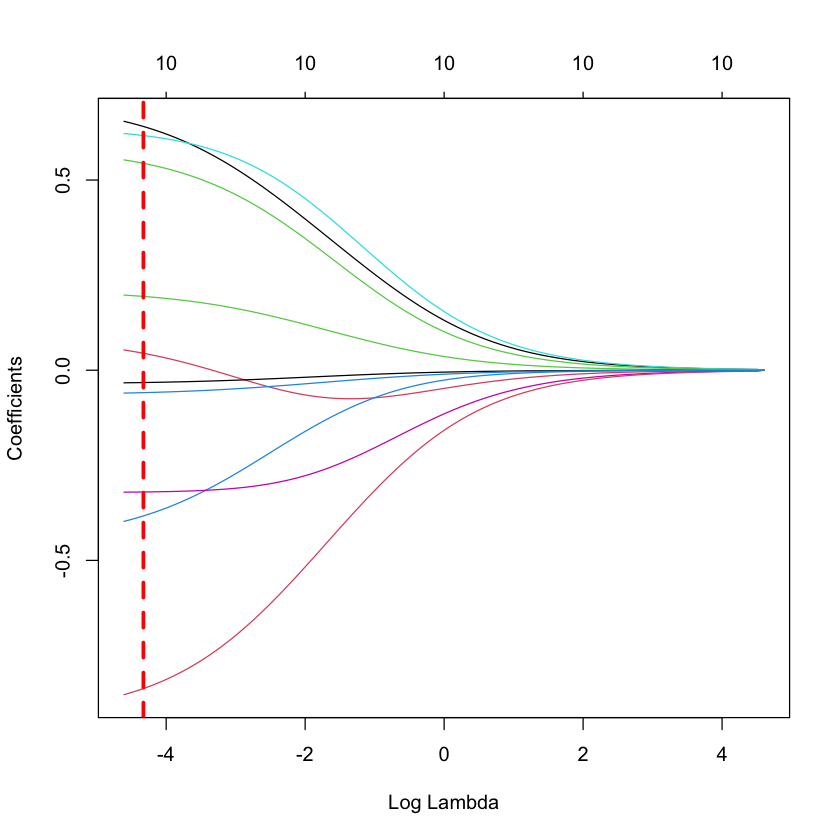

In [24]:
plot(emp_cv_lambda_ridge$glmnet.fit, "lambda")

abline(v = log(emp_lambda_max_AUC_ridge), 
       col = "red", 
       lwd = 3, 
       lty = 2)

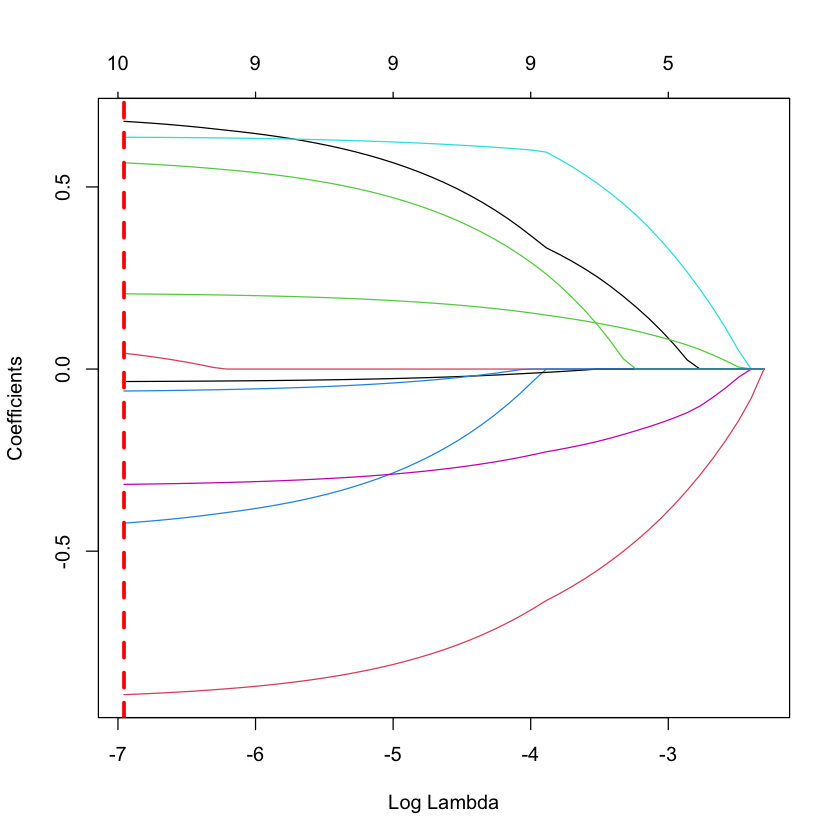

In [25]:
plot(emp_cv_lambda_lasso$glmnet.fit, "lambda")

abline(v = log(emp_lambda_max_AUC_lasso), 
       col = "red", 
       lwd = 3, 
       lty = 2)

The plot visualizes the estimated regression coefficients all over the $\lambda$ range with the vertical red dotted line representing the optimal $\lambda$ on the natural logarithm scale which balances complexity and regularization.

#### 5) Prediction Performance (Using Test Set)

In [26]:
# LASSO (Prediction on test set)

set.seed(123)
emp_pred_class <- round(predict(emp_ridge_max_AUC, 
                                newx = emp_X_test,
                                type = "response"), 0)

emp_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(emp_pred_class),
    reference = as.factor(emp_Y_test),
    positive = '1'
)

emp_confusion_matrix


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 336 185
         1  42  82
                                          
               Accuracy : 0.6481          
                 95% CI : (0.6098, 0.6849)
    No Information Rate : 0.586           
    P-Value [Acc > NIR] : 0.0007299       
                                          
                  Kappa : 0.2127          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3071          
            Specificity : 0.8889          
         Pos Pred Value : 0.6613          
         Neg Pred Value : 0.6449          
             Prevalence : 0.4140          
         Detection Rate : 0.1271          
   Detection Prevalence : 0.1922          
      Balanced Accuracy : 0.5980          
                                          
       'Positive' Class : 1               
                              

In [27]:
set.seed(123)
emp_pred_class <- round(predict(emp_ridge_max_AUC, 
                                newx = emp_X_test,
                                type = "response"), 0)

In [28]:
set.seed(123)
emp_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(emp_pred_class),
    reference = as.factor(emp_Y_test),
    positive = '1'
)

emp_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 336 185
         1  42  82
                                          
               Accuracy : 0.6481          
                 95% CI : (0.6098, 0.6849)
    No Information Rate : 0.586           
    P-Value [Acc > NIR] : 0.0007299       
                                          
                  Kappa : 0.2127          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3071          
            Specificity : 0.8889          
         Pos Pred Value : 0.6613          
         Neg Pred Value : 0.6449          
             Prevalence : 0.4140          
         Detection Rate : 0.1271          
   Detection Prevalence : 0.1922          
      Balanced Accuracy : 0.5980          
                                          
       'Positive' Class : 1               
                              

In [29]:
glance(emp_cv_lambda_ridge)

lambda.min,lambda.1se,nobs
<dbl>,<dbl>,<int>
0.01319583,90.95371,3257


Using threshold $p_0$ = 0.5, we have obtained a moderately good accuracy of 62.64% which is only better than randomly guessing. 

5) In 3 or 4 sentences give a brief interpretation of the results. If needed, comment on any unexpected result or potential problems with the analysis, and possible ways to address issues encountered. If results are as expected, explain how they address the question of interest. **Do not exceed the 4 sentences limit**.

We maximized the AUC by shrunking the coefficients towards 0 to reduce over-fitting and our intercept value is significantly larger which could be caused from strong regularization. 

Furthermore, the True Positive Rate is low at 19.10% and Specificity at 93.38% meaning that our model struggles at correctly identifying positive class 1 (Stay) and is a lot better at identifying negative class 0 (Leave), this result was expected because there is a class imbalance between classes with class 0 (Leave) nearly doubling class 1 (Stay). 

To address this, we should increase the training data to tackle any class imbalance or consider interactions or covariate transformations.

ANOVA

In [30]:
# Fit full model with glm
emp_glm_full <- glm(LeaveOrNot ~ ., family = binomial, data = training_emp)

# Fit reduced model with glm
emp_glm_reduced <- glm(LeaveOrNot ~ . - JoiningYear, family = binomial, data = training_emp)

# Perform ANOVA
anova(emp_glm_reduced, emp_glm_full, test = "Chisq")


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3247,3793.080,NA,NA,NA
2,3246,3704.376,1,88.70435,4.584562e-21


### NIKITA WORK CONT'D

In [55]:
# Adjust data types
# head(employee_data)
employee_data_f <- employee_data %>%
  mutate(
    Education = as.factor(Education),
    JoiningYear = as.factor(JoiningYear),
    City = factor(City, levels = c("Bangalore", "Pune", "New Delhi")),
    PaymentTier = as.factor(PaymentTier),
    Gender = factor(Gender, levels = c("Male", "Female")),
    EverBenched = factor(EverBenched, levels = c("Yes", "No")),
    # LeaveOrNot = as.factor(LeaveOrNot),
    Age = as.numeric(Age)
  ) |>
select(-ExperienceInCurrentDomain)

head(employee_data_f)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,LeaveOrNot
<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0
Bachelors,2013,Pune,1,28,Female,No,1
Bachelors,2014,New Delhi,3,38,Female,No,0
Masters,2016,Bangalore,3,27,Male,No,1
Masters,2017,Pune,3,24,Male,Yes,1
Bachelors,2016,Bangalore,3,22,Male,No,0


In [60]:
employee_encoded <- model.matrix(~ ., data = employee_data_f)

employee_encoded<- as.data.frame(employee_encoded) 

head(employee_encoded)

,(Intercept),EducationMasters,EducationPHD,JoiningYear2013,JoiningYear2014,JoiningYear2015,JoiningYear2016,JoiningYear2017,JoiningYear2018,CityPune,CityNew Delhi,PaymentTier2,PaymentTier3,Age,GenderFemale,EverBenchedNo,LeaveOrNot
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0,1,0,0,0,0,1,34,0,1,0
2,1,0,0,1,0,0,0,0,0,1,0,0,0,28,1,1,1
3,1,0,0,0,1,0,0,0,0,0,1,0,1,38,1,1,0
4,1,1,0,0,0,0,1,0,0,0,0,0,1,27,0,1,1
5,1,1,0,0,0,0,0,1,0,1,0,0,1,24,0,0,1
6,1,0,0,0,0,0,1,0,0,0,0,0,1,22,0,1,0


In [32]:
# FULL MODEL
emp_X_train <- model.matrix(object = LeaveOrNot ~ .,
                            data = training_emp)[, -1]

emp_Y_train <- training_emp[["LeaveOrNot"]]

emp_X_test <- model.matrix(object = LeaveOrNot ~ .,
  data = testing_emp)[, -1]

emp_Y_test <- testing_emp[["LeaveOrNot"]]

emp_cv_lambda_lasso <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 1,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_lambda_max_AUC_lasso <- emp_cv_lambda_lasso$lambda.min
emp_lambda_max_AUC_lasso

emp_lasso_max_AUC <- glmnet(
        x = emp_X_train,
        y = emp_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = emp_lambda_max_AUC_lasso)




[1] 0.0009528454

In [67]:
# Preparing model matrix for `glmnet` (using all predictors)
emp_X_train <- model.matrix(object = LeaveOrNot ~ JoiningYear+City+PaymentTier+Gender,
                            data = training_emp)[, -1]

emp_Y_train <- training_emp[["LeaveOrNot"]]

emp_X_test <- model.matrix(object = LeaveOrNot ~ JoiningYear+City+PaymentTier+Gender,
  data = testing_emp)[, -1]

emp_Y_test <- testing_emp[["LeaveOrNot"]]


# Ridge Regression
emp_cv_lambda_ridge <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 0,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_cv_lambda_ridge



# Lasso Regression
emp_cv_lambda_lasso <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 1,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_cv_lambda_lasso


Call:  cv.glmnet(x = emp_X_train, y = emp_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure       SE Nonzero
min   0.04    84  0.6959 0.009546       4
1se  90.95     2  0.6910 0.009178       4


Call:  cv.glmnet(x = emp_X_train, y = emp_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.00889    27  0.6932 0.009953       4
1se 0.06269     6  0.6848 0.010849       4

In [67]:
# Preparing model matrix for `glmnet` (using all predictors)
emp_X_train <- model.matrix(object = LeaveOrNot ~ JoiningYear+City+PaymentTier+Gender,
                            data = training_emp)[, -1]

emp_Y_train <- training_emp[["LeaveOrNot"]]

emp_X_test <- model.matrix(object = LeaveOrNot ~ JoiningYear+City+PaymentTier+Gender,
  data = testing_emp)[, -1]

emp_Y_test <- testing_emp[["LeaveOrNot"]]


# Ridge Regression
emp_cv_lambda_ridge <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 0,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_cv_lambda_ridge



# Lasso Regression
emp_cv_lambda_lasso <- cv.glmnet(x = emp_X_train,
                                 y = emp_Y_train,
                                 alpha = 1,
                                 family = "binomial",
                                 type.measure = "auc",
                                 nfolds = 10)

emp_cv_lambda_lasso


Call:  cv.glmnet(x = emp_X_train, y = emp_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure       SE Nonzero
min   0.04    84  0.6959 0.009546       4
1se  90.95     2  0.6910 0.009178       4


Call:  cv.glmnet(x = emp_X_train, y = emp_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.00889    27  0.6932 0.009953       4
1se 0.06269     6  0.6848 0.010849       4

In [68]:
emp_lambda_max_AUC_ridge <- emp_cv_lambda_ridge$lambda.min
emp_lambda_max_AUC_ridge

emp_lambda_max_AUC_lasso <- emp_cv_lambda_lasso$lambda.min
emp_lambda_max_AUC_lasso

[1] 0.04422716

[1] 0.008886268

In [69]:
emp_ridge_max_AUC <- glmnet(
        x = emp_X_train,
        y = emp_Y_train,
        alpha = 0,
        family = "binomial",
        lambda = emp_lambda_max_AUC_ridge)

emp_ridge_max_AUC
coef(emp_ridge_max_AUC)

# LASSO
emp_lasso_max_AUC <- glmnet(
        x = emp_X_train,
        y = emp_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = emp_lambda_max_AUC_lasso)

emp_ridge_max_AUC
coef(emp_lasso_max_AUC)


Call:  glmnet(x = emp_X_train, y = emp_Y_train, family = "binomial",      alpha = 0, lambda = emp_lambda_max_AUC_ridge) 

  Df %Dev  Lambda
1  4 8.42 0.04423

5 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -340.9060723
JoiningYear    0.1695183
City           0.2908514
PaymentTier   -0.3400453
Gender        -0.6295001


Call:  glmnet(x = emp_X_train, y = emp_Y_train, family = "binomial",      alpha = 0, lambda = emp_lambda_max_AUC_ridge) 

  Df %Dev  Lambda
1  4 8.42 0.04423

5 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -371.0195934
JoiningYear    0.1844660
City           0.3015927
PaymentTier   -0.3213317
Gender        -0.6814198

In [71]:
# RIDGE 
emp_pred_class <- round(predict(emp_ridge_max_AUC, 
                                newx = emp_X_test,
                                type = "response"), 0)

emp_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(emp_pred_class),
    reference = as.factor(emp_Y_test),
    positive = '1'
)

emp_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 349 199
         1  29  68
                                          
               Accuracy : 0.6465          
                 95% CI : (0.6082, 0.6834)
    No Information Rate : 0.586           
    P-Value [Acc > NIR] : 0.0009639       
                                          
                  Kappa : 0.1963          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.2547          
            Specificity : 0.9233          
         Pos Pred Value : 0.7010          
         Neg Pred Value : 0.6369          
             Prevalence : 0.4140          
         Detection Rate : 0.1054          
   Detection Prevalence : 0.1504          
      Balanced Accuracy : 0.5890          
                                          
       'Positive' Class : 1               
                              

In [83]:
# LASSO 
threshold <- 0.5
emp_pred_class <- ifelse(predict(emp_lasso_max_AUC, 
                                 newx = emp_X_test,
                                 type = "response") > threshold, 1, 0)

emp_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(emp_pred_class),
    reference = as.factor(emp_Y_test),
    positive = '1'
)

emp_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 343 195
         1  35  72
                                          
               Accuracy : 0.6434          
                 95% CI : (0.6051, 0.6804)
    No Information Rate : 0.586           
    P-Value [Acc > NIR] : 0.001649        
                                          
                  Kappa : 0.1942          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.2697          
            Specificity : 0.9074          
         Pos Pred Value : 0.6729          
         Neg Pred Value : 0.6375          
             Prevalence : 0.4140          
         Detection Rate : 0.1116          
   Detection Prevalence : 0.1659          
      Balanced Accuracy : 0.5885          
                                          
       'Positive' Class : 1               
                              

In [98]:
# Preparing model matrix for `glmnet` (using all predictors)
emp_X_train <- model.matrix(object = LeaveOrNot ~ JoiningYear+City+PaymentTier+Gender,
                            data = training_emp)[, -1]

emp_Y_train <- training_emp[["LeaveOrNot"]]

emp_X_test <- model.matrix(object = LeaveOrNot ~ JoiningYear+City+PaymentTier+Gender,
  data = testing_emp)[, -1]

emp_Y_test <- testing_emp[["LeaveOrNot"]]


emp_glm <- glm(formula =LeaveOrNot~JoiningYear+City+PaymentTier+Gender,
                  data = training_emp,
                  family = binomial)





In [99]:
threshold <- 0.5
emp_pred_class <- ifelse(predict(emp_glm, 
                                 newx = emp_X_test,
                                 type = "response") > threshold, 1, 0)
emp_pred_class

1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   0    0    0    0    0    0    0    0    1    0    0    0    0    0    0    1 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
   0    0    0    0    0    1    0    0    0    0    1    0    0    0    0    0 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
   0    0    1    0    0    0    0    0    1    0    0    0    0    0    0    0 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
   0    0    0    0    0    1    0    1    0    0    0    0    1    0    0    0 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
   0    0    0    0    0    0    0    0    0    0    1    1    0    0    1    1 
  97   98   99  100  101  102  103  104  105  106  107  108  109  110  111  112 
   0    1    0    0    1    0    0    0    0    0    0    0    1    0    0    1 
 113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128 
   0    0    0    0    0    0    1    1    1    0    0    1    0    0    0    0 
 129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144 
   0    0    0    1    0    0    0    0    0    0    0    0    1    0    0    0 
 145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160 
   0    0    0    0    0    0    0    1    1    0    0    0    0    0    0    0 
 161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176 
   1    0    0    0    0    0    1    1    0    0    0    1    0    0    1    1 
 177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192 
   0    1    0    0    0    0    0    1    1    0    0    0    0    0    0    0 
 193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 209  210  211  212  213  214  215  216  217  218  219  220  221  222  223  224 
   0    0    0    0    0    0    1    0    1    0    1    0    0    0    0    0 
 225  226  227  228  229  230  231  232  233  234  235  236  237  238  239  240 
   1    1    0    0    0    1    0    0    0    1    0    0    0    0    0    0 
 241  242  243  244  245  246  247  248  249  250  251  252  253  254  255  256 
   0    1    0    0    1    0    0    0    0    0    0    1    0    0    0    1 
 257  258  259  260  261  262  263  264  265  266  267  268  269  270  271  272 
   1    0    0    1    0    1    0    0    0    0    0    0    0    0    0    0 
 273  274  275  276  277  278  279  280  281  282  283  284  285  286  287  288 
   0    0    0    1    1    0    0    1    0    1    0    0    0    0    0    0 
 289  290  291  292  293  294  295  296  297  298  299  300  301  302  303  304 
   0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0 
 305  306  307  308  309  310  311  312  313  314  315  316  317  318  319  320 
   0    0    0    0    1    0    0    0    1    0    0    0    0    0    1    0 
 321  322  323  324  325  326  327  328  329  330  331  332  333  334  335  336 
   0    0    1    0    0    0    1    1    1    0    1    0    1    0    0    0 
 337  338  339  340  341  342  343  344  345  346  347  348  349  350  351  352 
   0    1    1    1    0    0    0    0    0    0    0    0    0    1    0    0 
 353  354  355  356  357  358  359  360  361  362  363  364  365  366  367  368 
   0    0    0    0    1    0    0    0    0    0    1    1    0    0    1    1 
 369  370  371  372  373  374  375  376  377  378  379  380  381  382  383  384 
   0    0    0    0    0    0    0    1    0    0    0    0    1    0    0    0 
 385  386  387  388  389  390  391  392  393  394  395  396  397  398  399  400 
   0    0    0    0    0    0    0

In [109]:
# Convert predictions and actual values to factors
emp_pred_class <- factor(emp_pred_class, levels = c(0, 1))
emp_Y_test <- factor(emp_Y_test, levels = c(0, 1))

# Build the confusion matrix
emp_confusion_matrix <- confusionMatrix(
  data = emp_pred_class,
  reference = emp_Y_test,
  positive = "1" # Specify the positive class
)

# Print the confusion matrix
print(emp_confusion_matrix)

ERROR: Error in table(data, reference, dnn = dnn, ...): all arguments must have the same length


In [107]:
emp_pred_class <- factor(emp_pred_class, levels = c(0, 1))
emp_Y_test <- factor(emp_Y_test, levels = c(0, 1))

In [111]:
length(emp_pred_class) # Length of predictions
length(emp_Y_test)      # Length of true labels

[1] 3257

[1] 645

In [110]:
str(emp_pred_class)
str(emp_Y_test)

 Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 2 1 ...
 - attr(*, "names")= chr [1:3257] "1" "2" "3" "4" ...
 Factor w/ 2 levels "0","1": 1 2 1 1 1 2 2 1 1 1 ...
